<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 05 &mdash; Generated Data**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Simple Example

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import StandardScaler

In [3]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
x = np.linspace(-2, 2, 500)

In [5]:
def f(x):
    return x ** 3

In [6]:
y = f(x)

In [7]:
scaler = StandardScaler()

In [8]:
y_ = scaler.fit_transform(y.reshape(-1, 1))

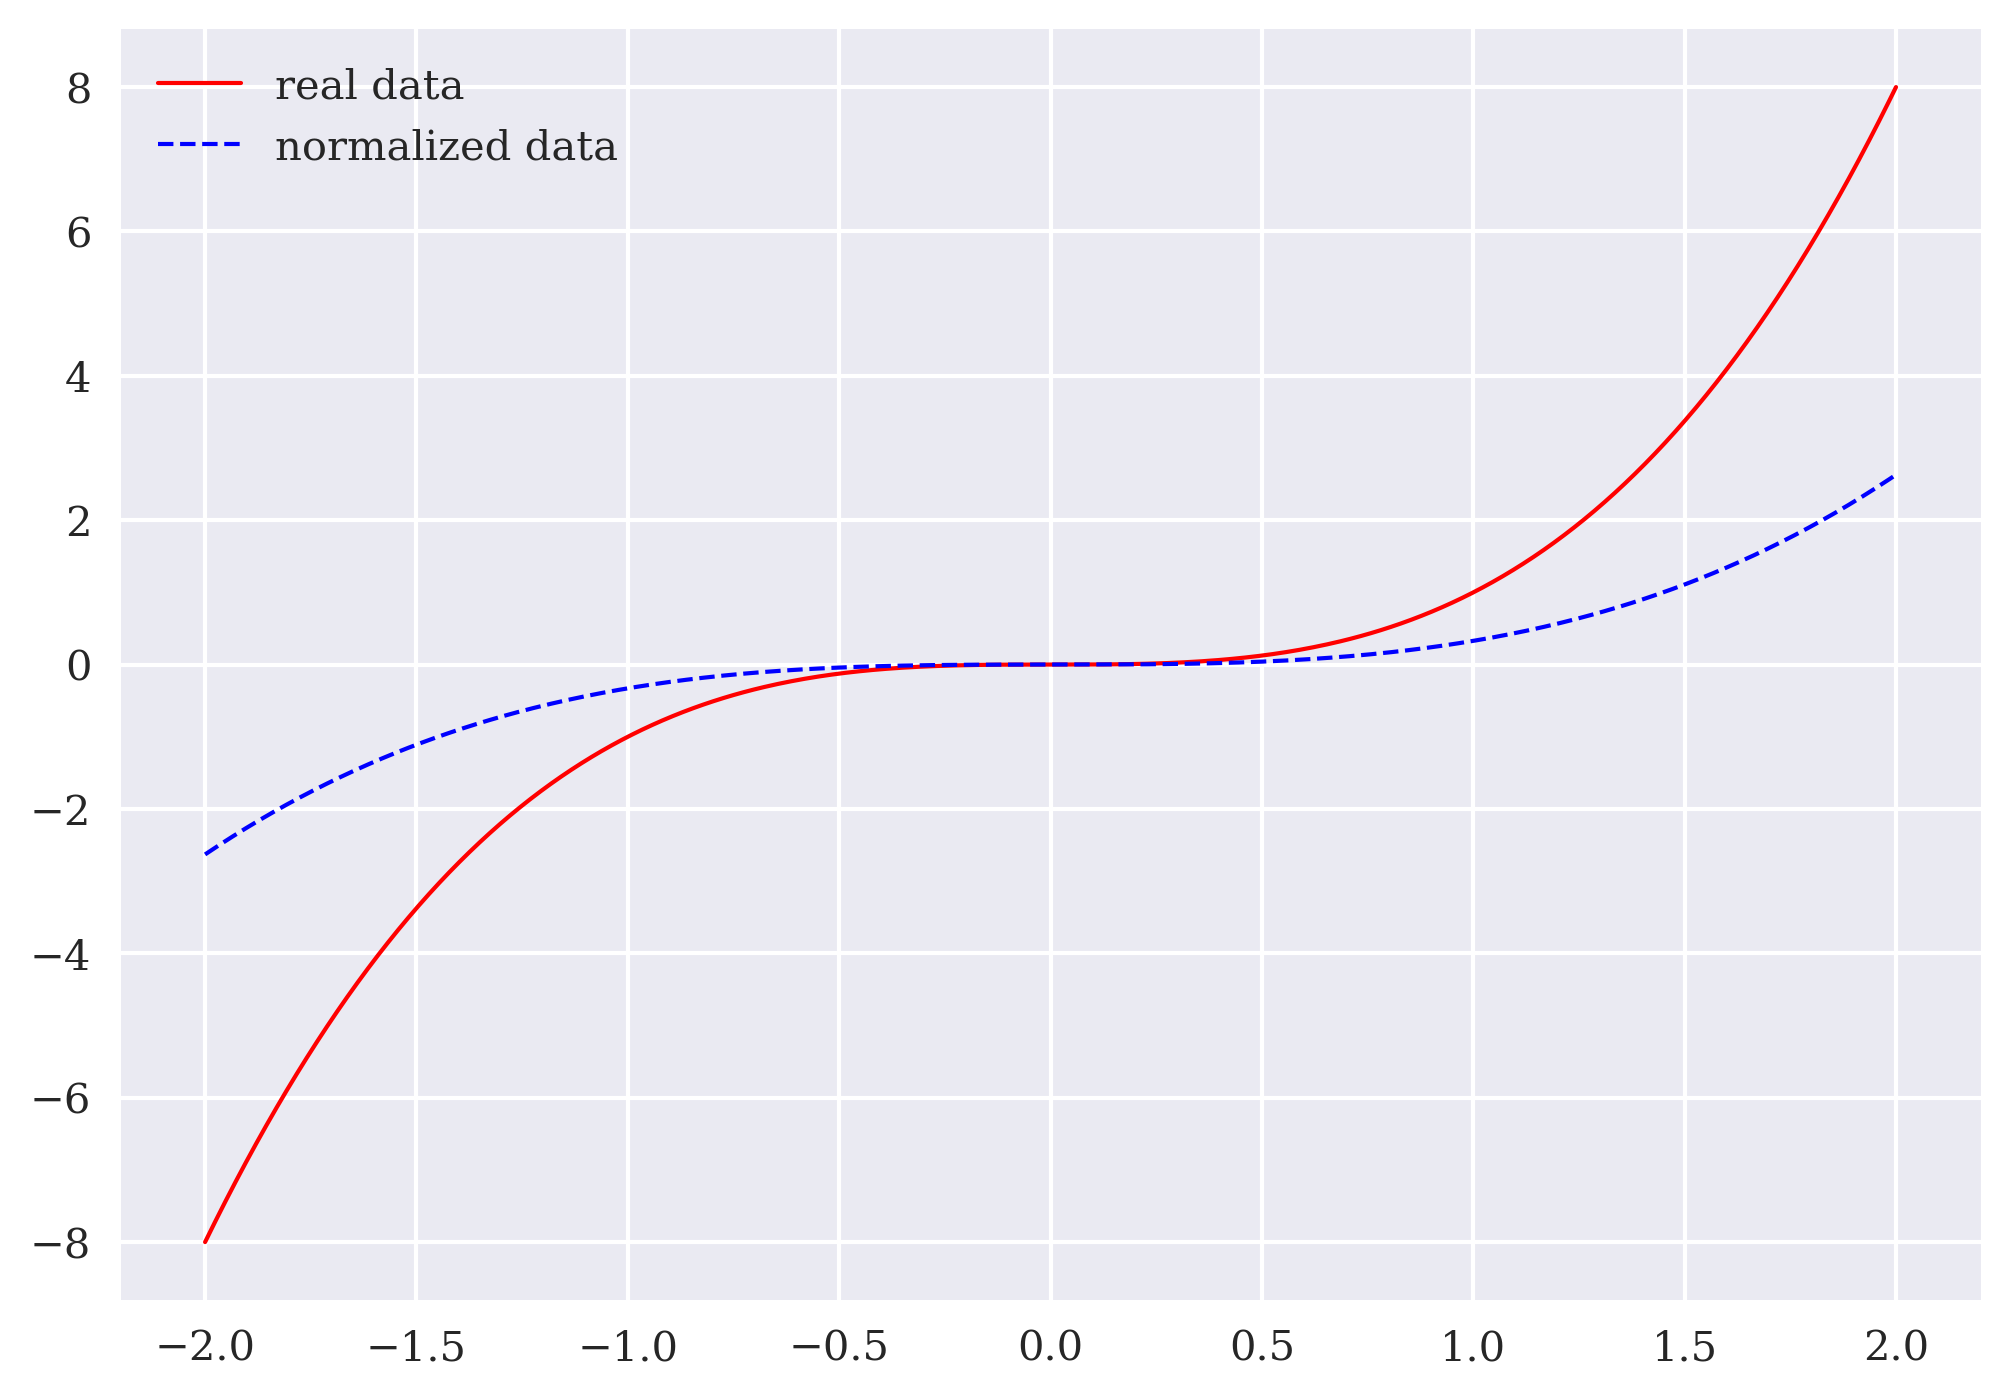

In [9]:
plt.plot(x, y, 'r', lw=1.0,
         label='real data')
plt.plot(x, y_, 'b--', lw=1.0,
         label='normalized data')
plt.legend();

### Model Training

In [10]:
def create_generator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

In [11]:
def create_discriminator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [12]:
def create_gan(generator, discriminator, lr=0.001):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr))
    return model

In [13]:
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator, 0.0001)

In [14]:
from numpy.random import default_rng

In [15]:
rng = default_rng(seed=100)

In [16]:
def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))
        synthetic_data = generator.predict(noise, verbose=False)

        # Train discriminator
        real_data = y_[rng.integers(0, len(y_), batch_size)]
        discriminator.train_on_batch(real_data, np.ones(batch_size))
        discriminator.train_on_batch(synthetic_data,
                                     np.zeros(batch_size))

        # Train generator
        noise = rng.normal(0, 1, (batch_size, 1))
        gan.train_on_batch(noise, np.ones(batch_size))

        # Print progress
        if epoch % 1000 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

In [17]:
%%time
real_data, synthetic_data = train_models(y_, epochs=5001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
CPU times: user 2min 1s, sys: 13.6 s, total: 2min 14s
Wall time: 2min 6s


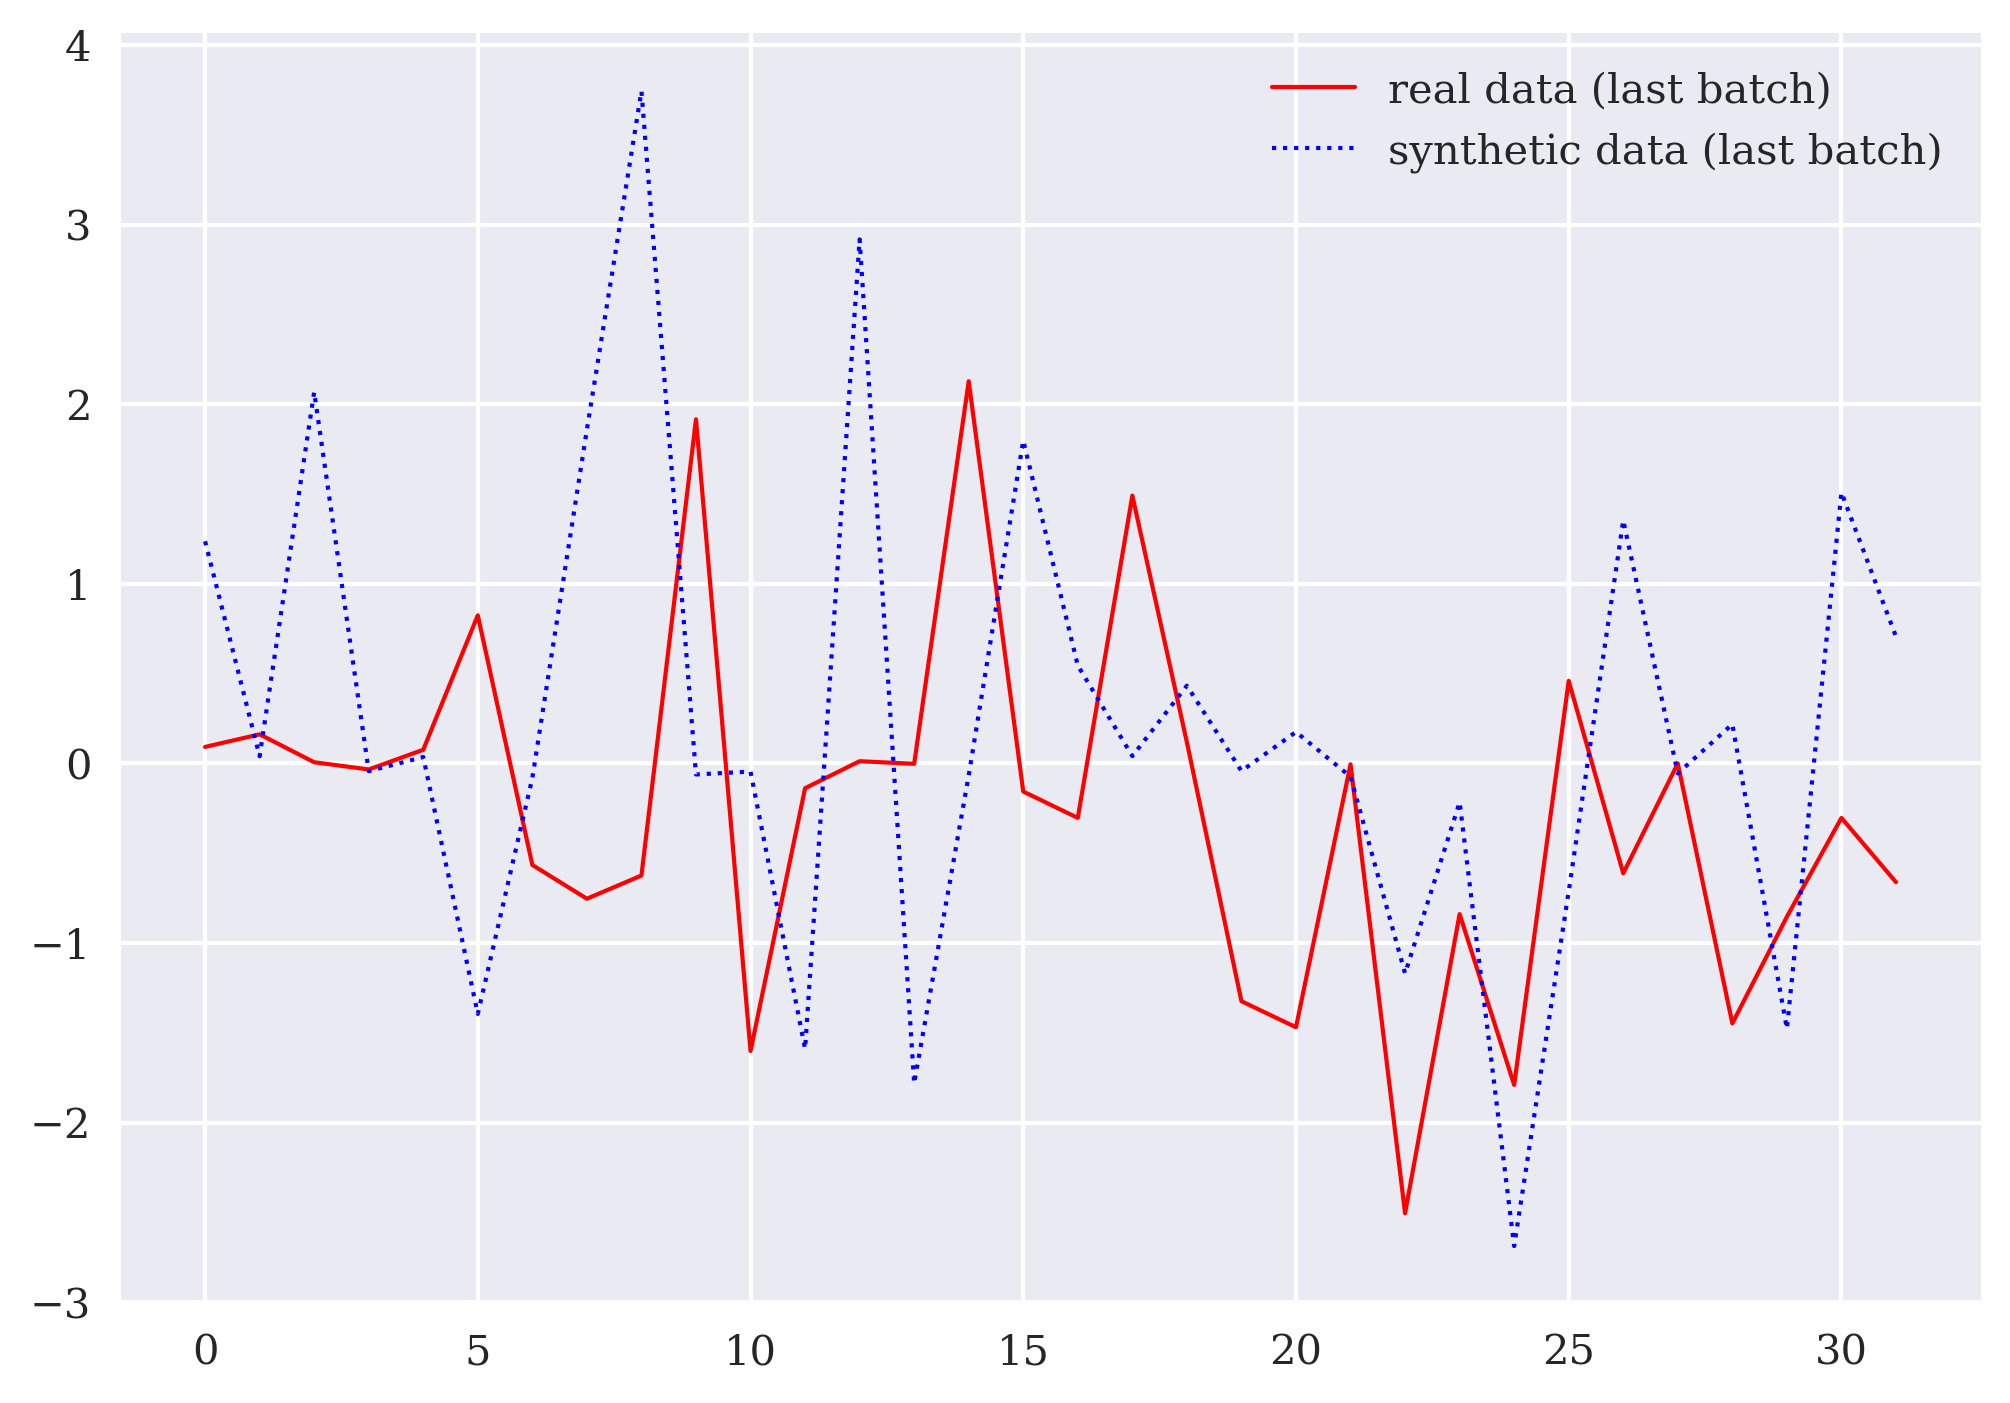

In [18]:
plt.plot(real_data, 'r', lw=1.0,
         label='real data (last batch)')
plt.plot(synthetic_data, 'b:', lw=1.0,
         label='synthetic data (last batch)')
plt.legend();

In [19]:
data = pd.DataFrame({'real': y}, index=x)

In [20]:
N = 5
for i in range(N):
    noise = rng.normal(0, 1, (len(y), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)

In [21]:
data.describe().round(3)

,real,synth_00,synth_01,synth_02,synth_03,synth_04
count,500.000,500.000,500.000,500.000,500.000,500.000
mean,-0.000,-0.039,-0.038,0.175,-0.009,-0.022
std,3.045,2.884,3.013,2.881,3.017,3.151
min,-8.000,-10.775,-13.484,-9.209,-8.262,-10.524
25%,-1.000,-0.980,-1.005,-0.630,-0.837,-0.854
50%,-0.000,-0.095,-0.077,-0.021,-0.095,-0.022
75%,1.000,0.754,0.904,1.131,0.999,1.082
max,8.000,11.857,11.569,10.124,9.912,8.738


In [22]:
((data.apply(np.sort)['real'] -
  data.apply(np.sort)['synth_00']) ** 2).mean()

0.16332014352347354

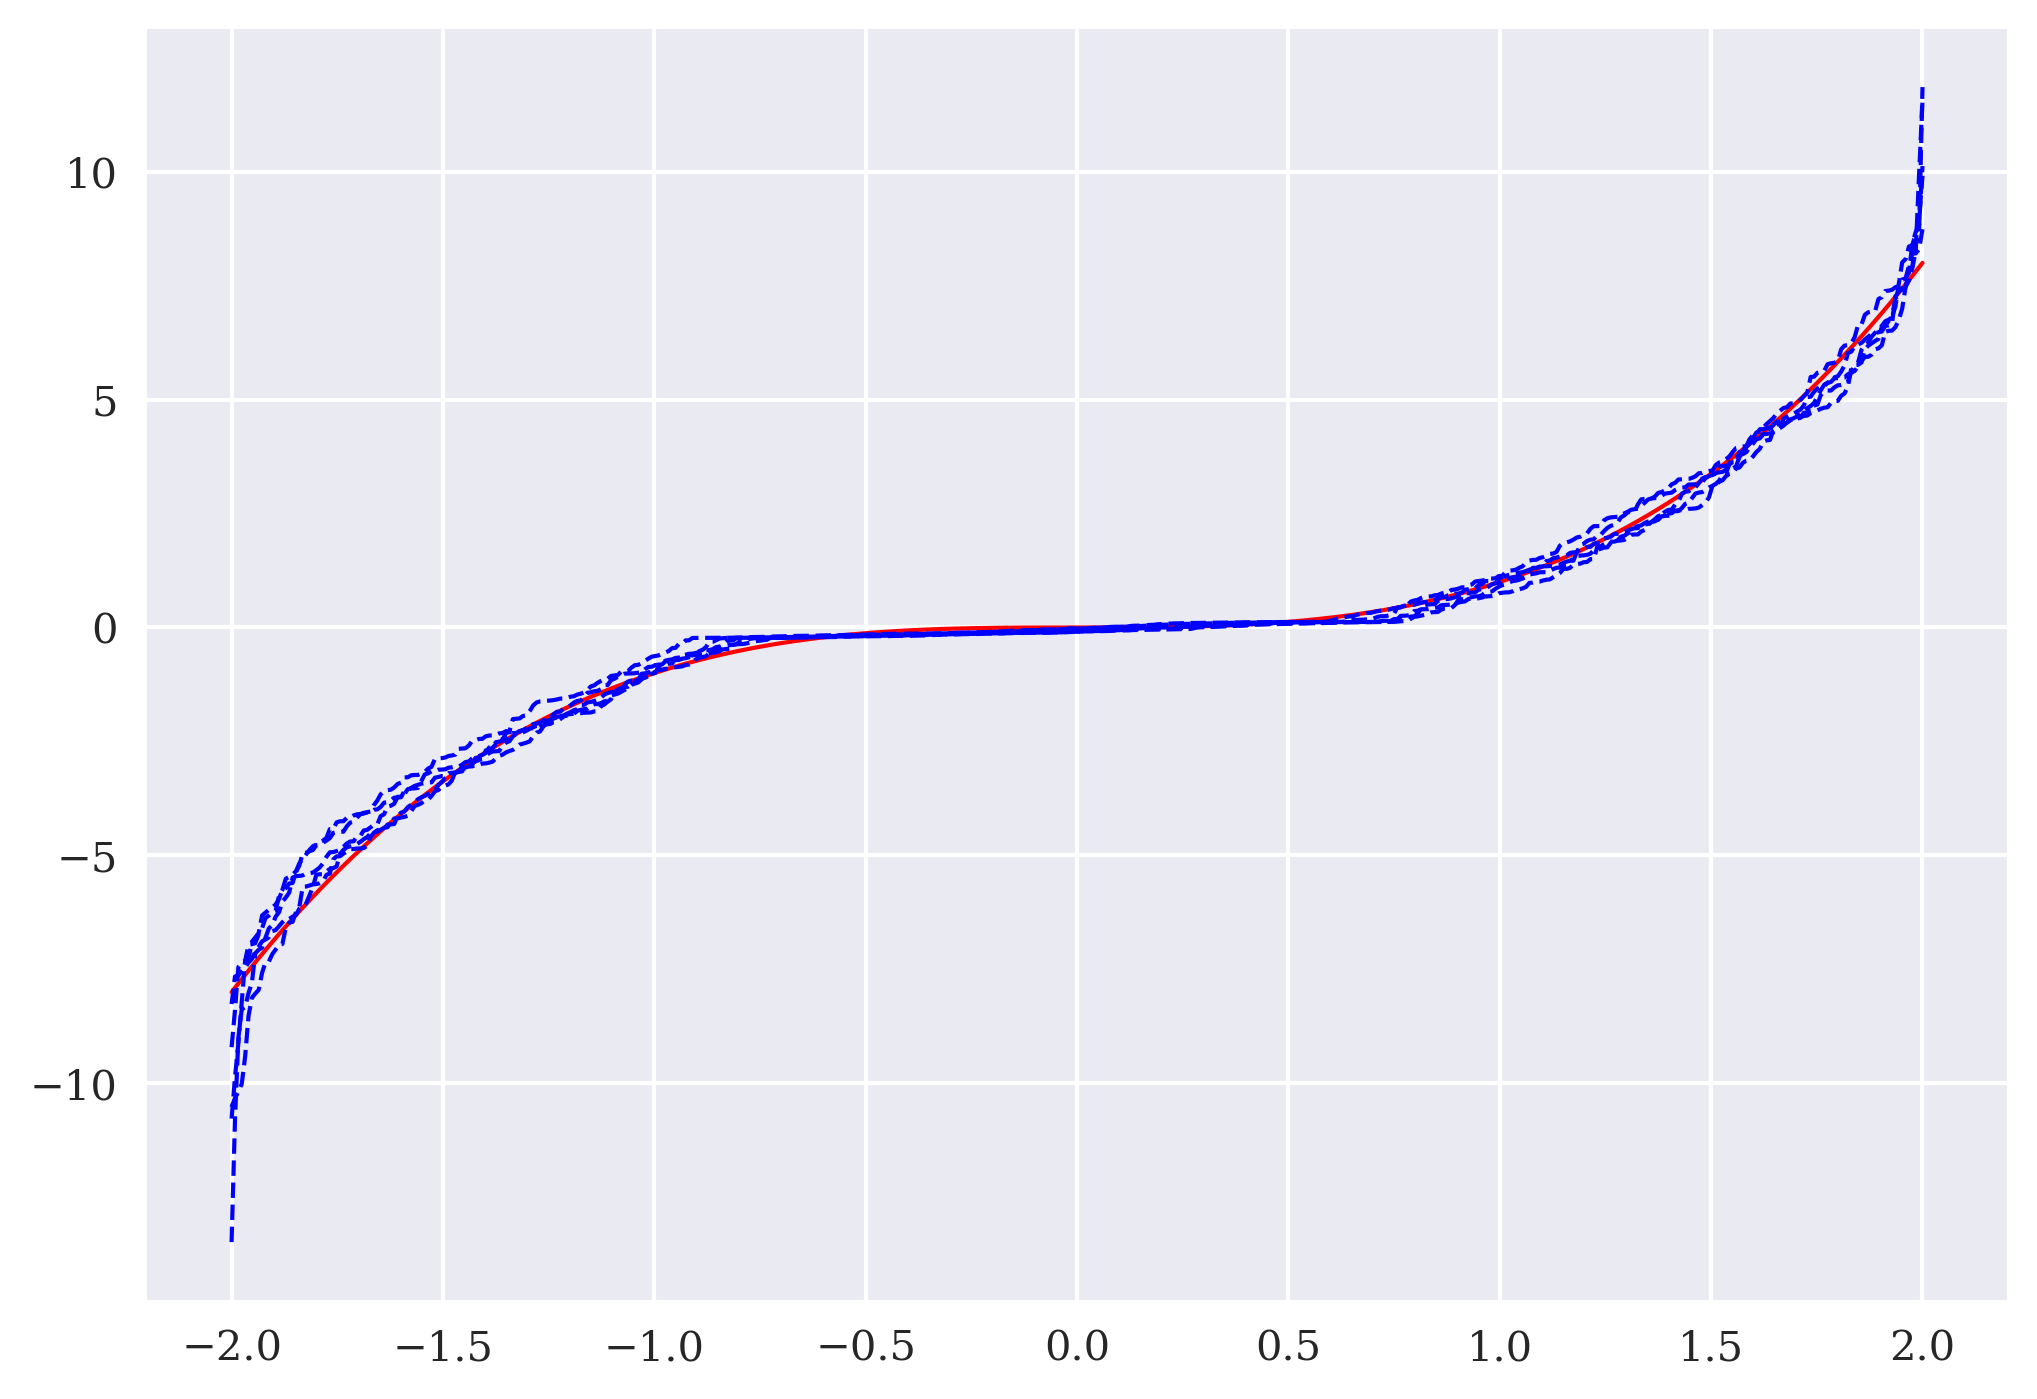

In [23]:
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False);

## Financial Example

In [24]:
raw = pd.read_csv('https://certificate.tpq.io/rl4finance.csv',
                 index_col=0, parse_dates=True).dropna()

In [25]:
rets = raw['GLD'].iloc[-2 * 252:]
rets = np.log((rets / rets.shift(1)).dropna())
rets = rets.values

In [26]:
scaler = StandardScaler()

In [27]:
rets_ = scaler.fit_transform(rets.reshape(-1, 1))

In [28]:
rng = default_rng(100)
tf.random.set_seed(100)

In [29]:
generator = create_generator(hu=24)
discriminator = create_discriminator(hu=24)
gan = create_gan(generator, discriminator, lr=0.0001)

In [30]:
%time rd, sd = train_models(y_=rets_, epochs=5001, batch_size=32)

Epoch: 0
Epoch: 1000
Epoch: 2000
Epoch: 3000
Epoch: 4000
Epoch: 5000
CPU times: user 2min 1s, sys: 14.1 s, total: 2min 16s
Wall time: 2min 6s


In [31]:
data = pd.DataFrame({'real': rets})

In [32]:
N = 25

In [33]:
for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(
                                            synthetic_data)

In [34]:
res = data.describe().round(4)
res.iloc[:, :5]

,real,synth_00,synth_01,synth_02,synth_03
count,503.0000,503.0000,503.0000,503.0000,503.0000
mean,0.0002,-0.0008,-0.0003,0.0001,0.0002
std,0.0090,0.0088,0.0083,0.0084,0.0085
min,-0.0302,-0.0287,-0.0231,-0.0280,-0.0279
25%,-0.0052,-0.0062,-0.0055,-0.0052,-0.0050
50%,0.0003,-0.0003,0.0003,0.0014,0.0009
75%,0.0054,0.0044,0.0047,0.0047,0.0049
max,0.0316,0.0335,0.0280,0.0272,0.0332


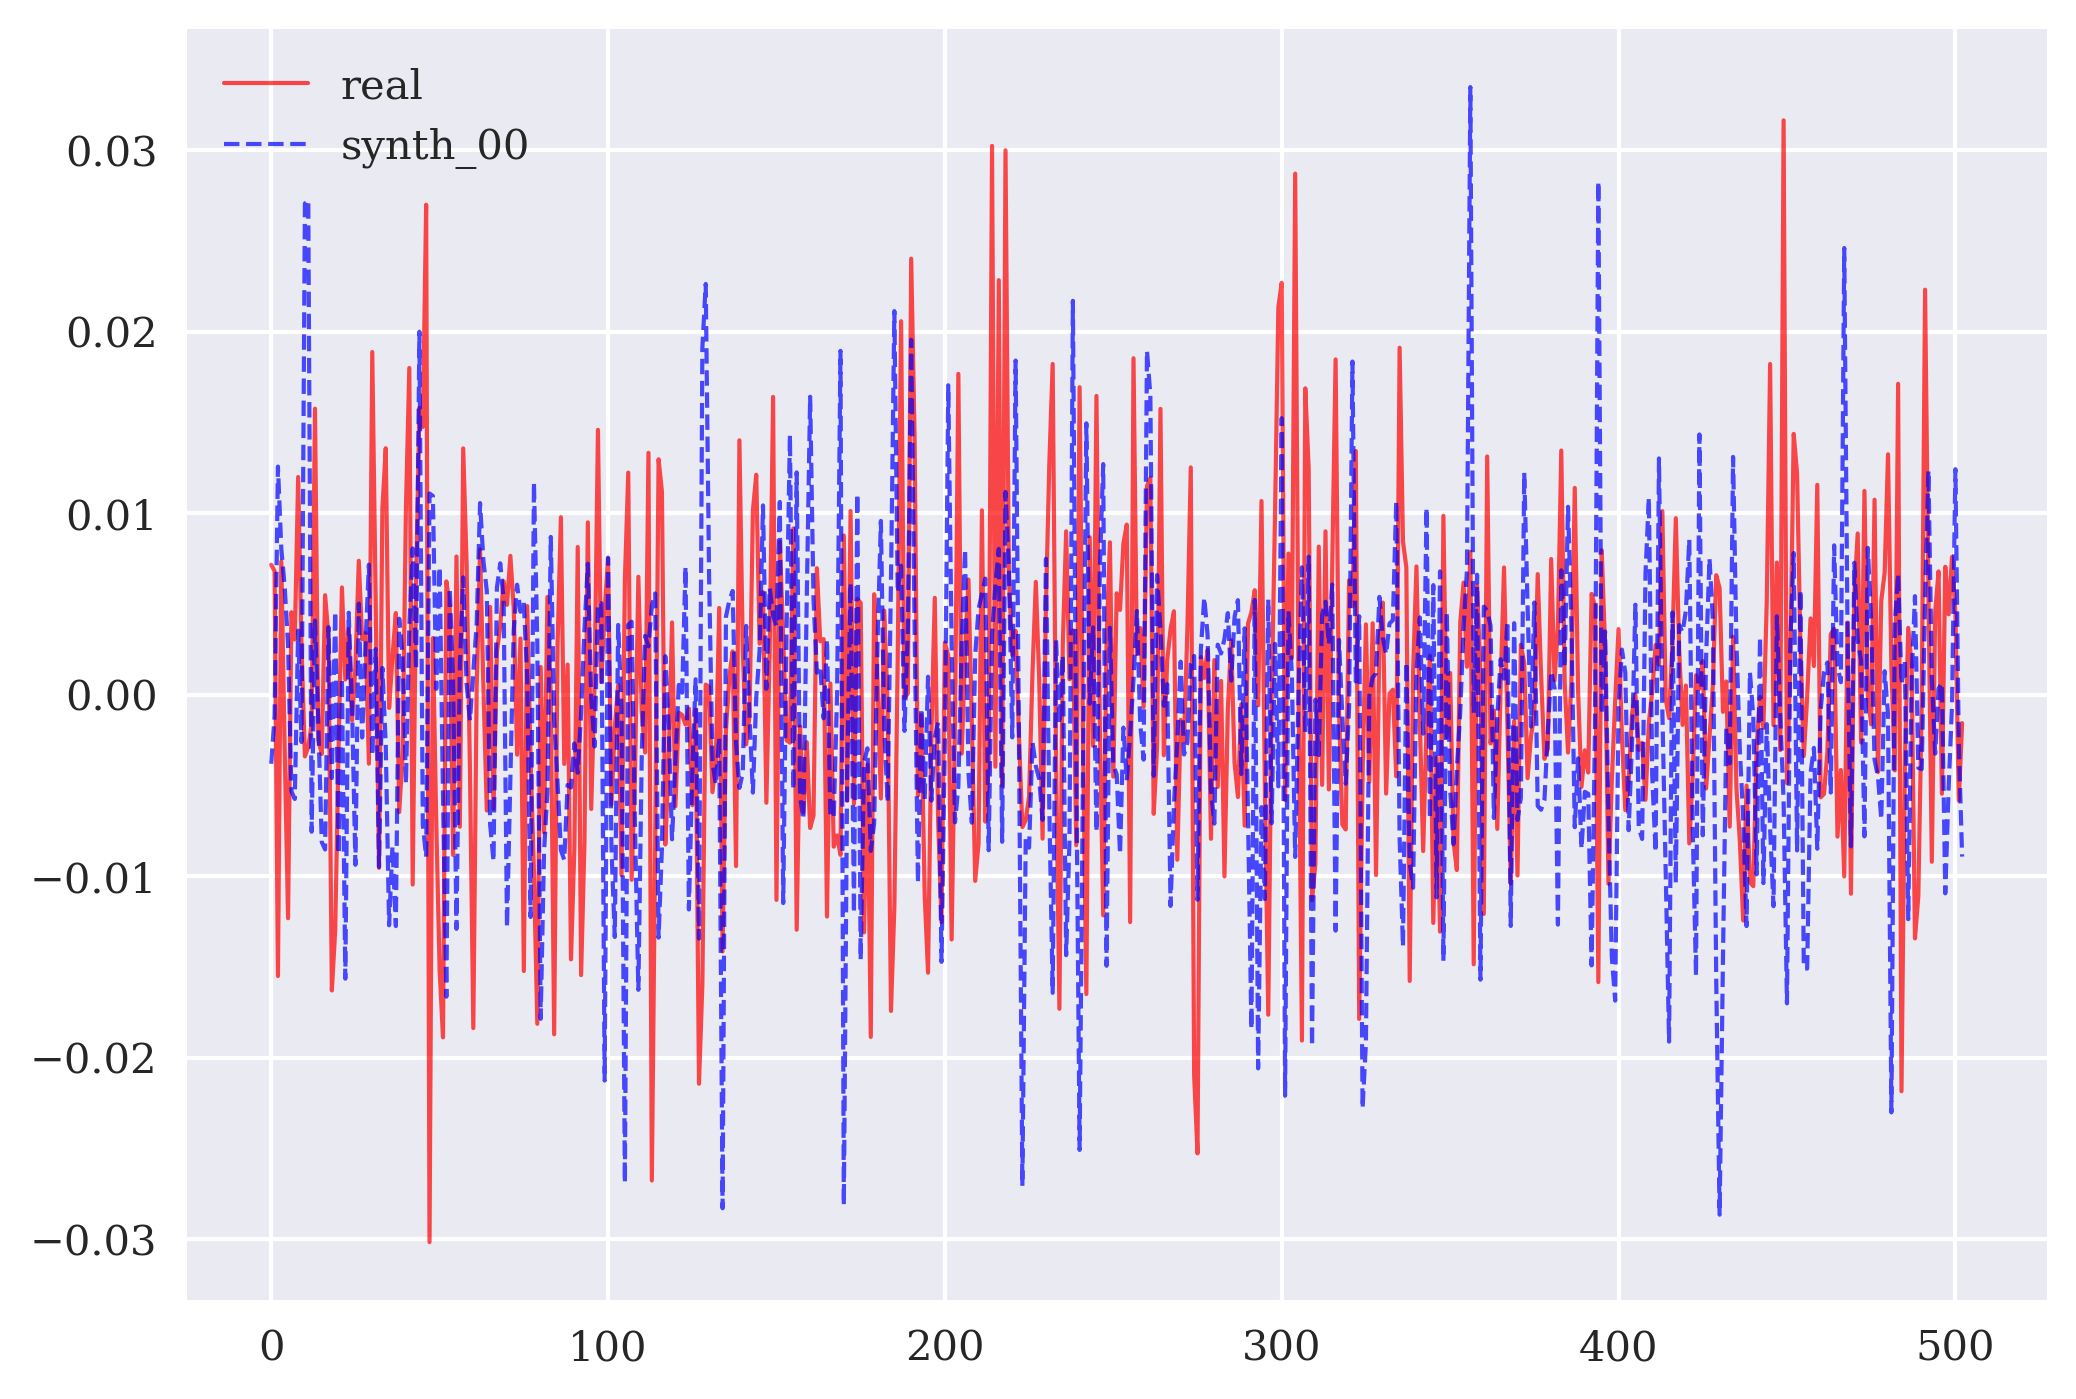

In [35]:
data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7);

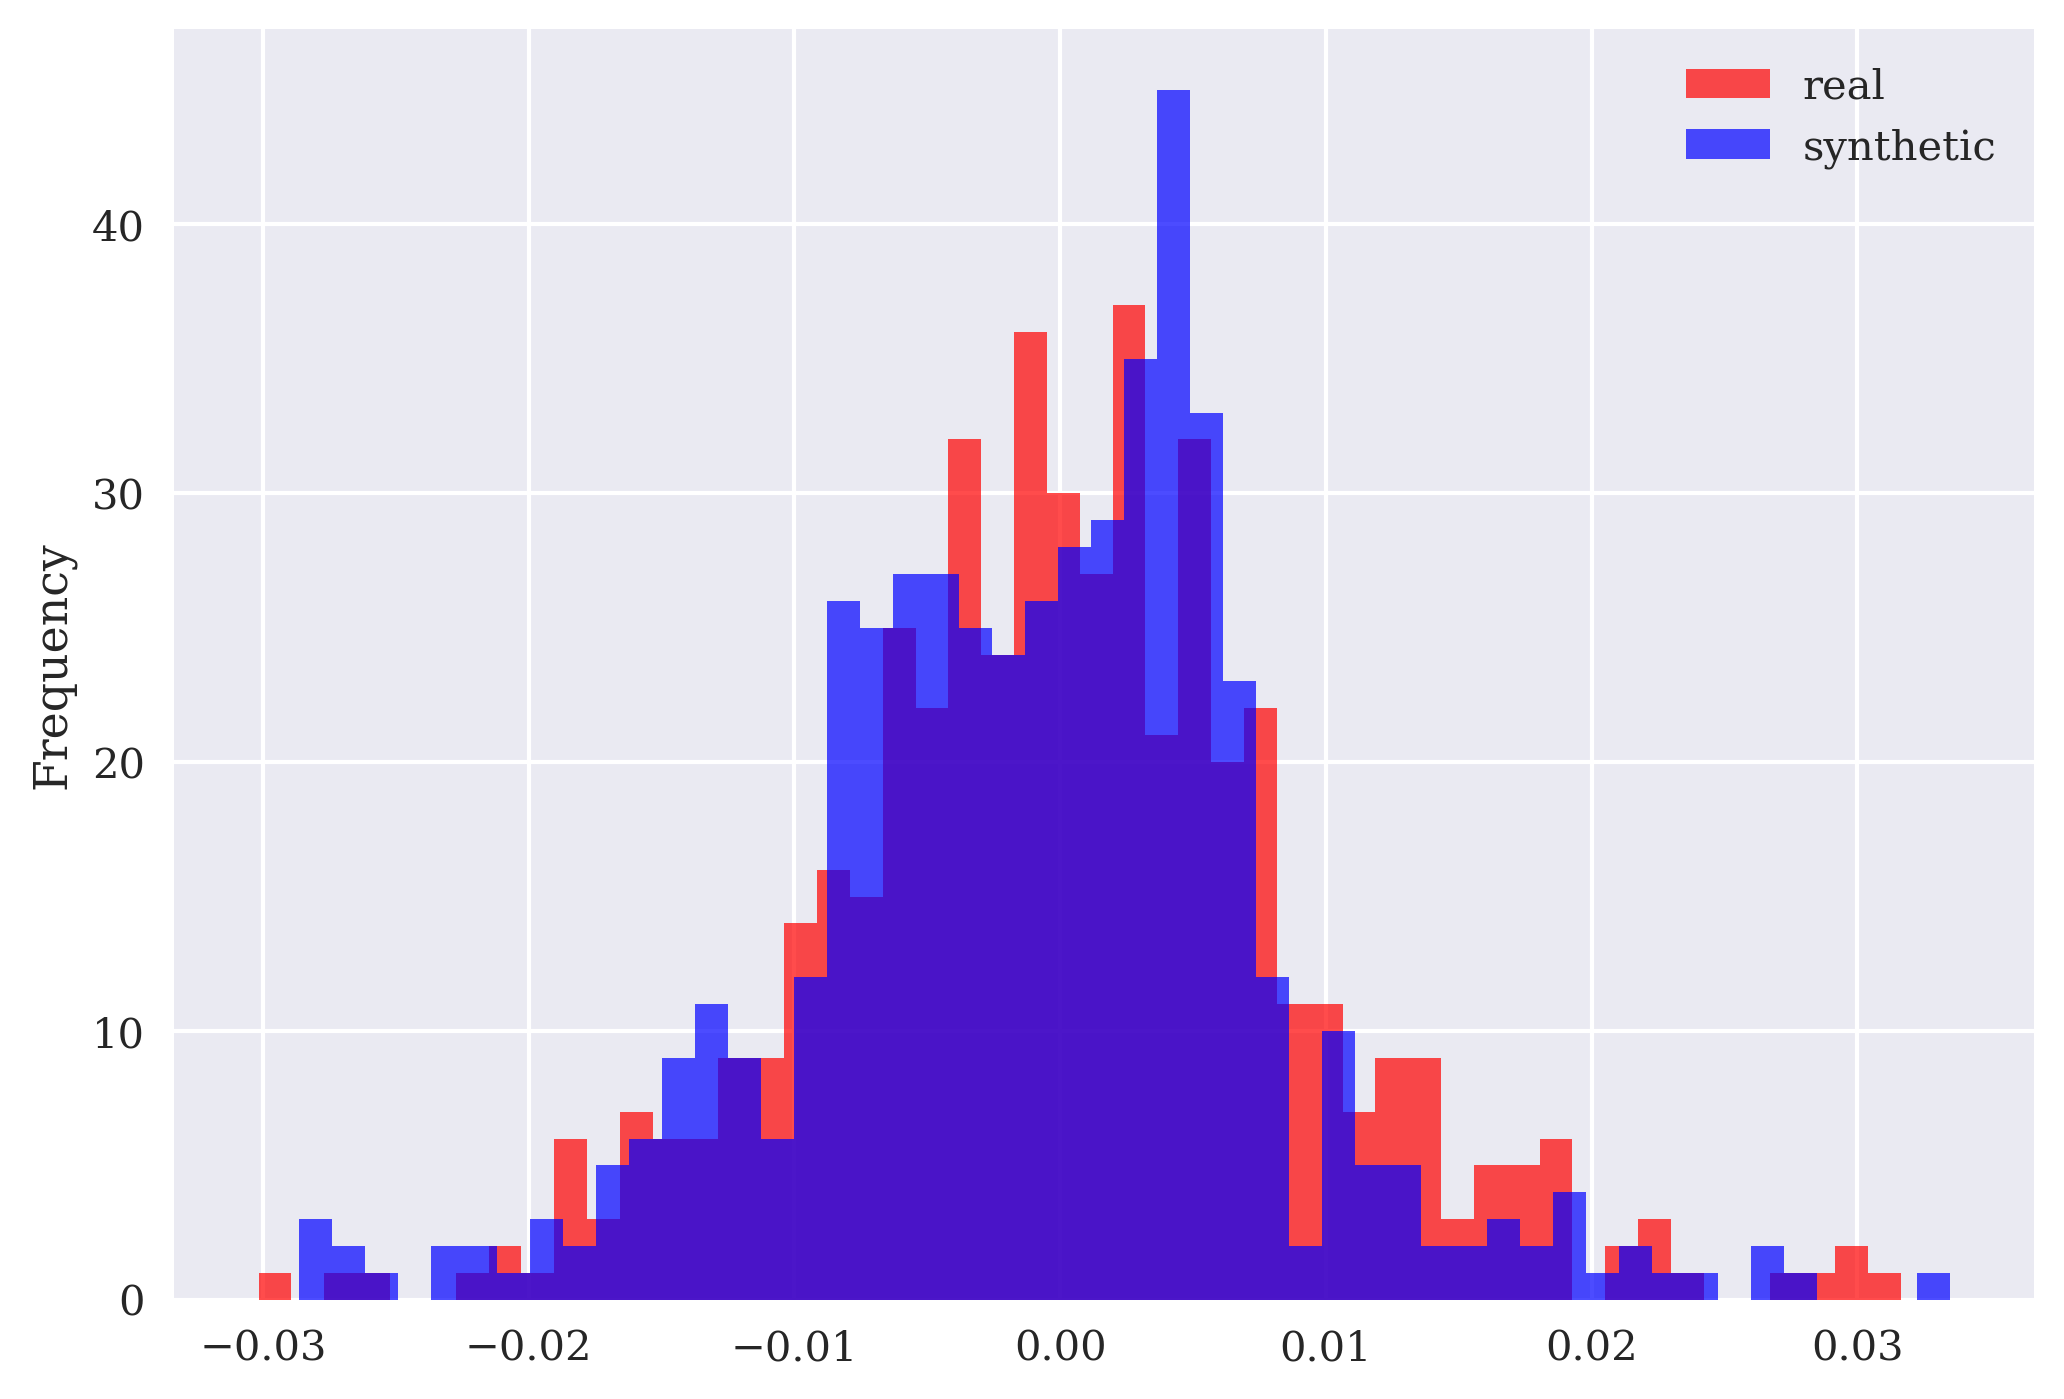

In [36]:
data['real'].plot(kind='hist', bins=50, label='real',
                  color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7,
                  label='synthetic', color='b', sharex=True)
plt.legend();

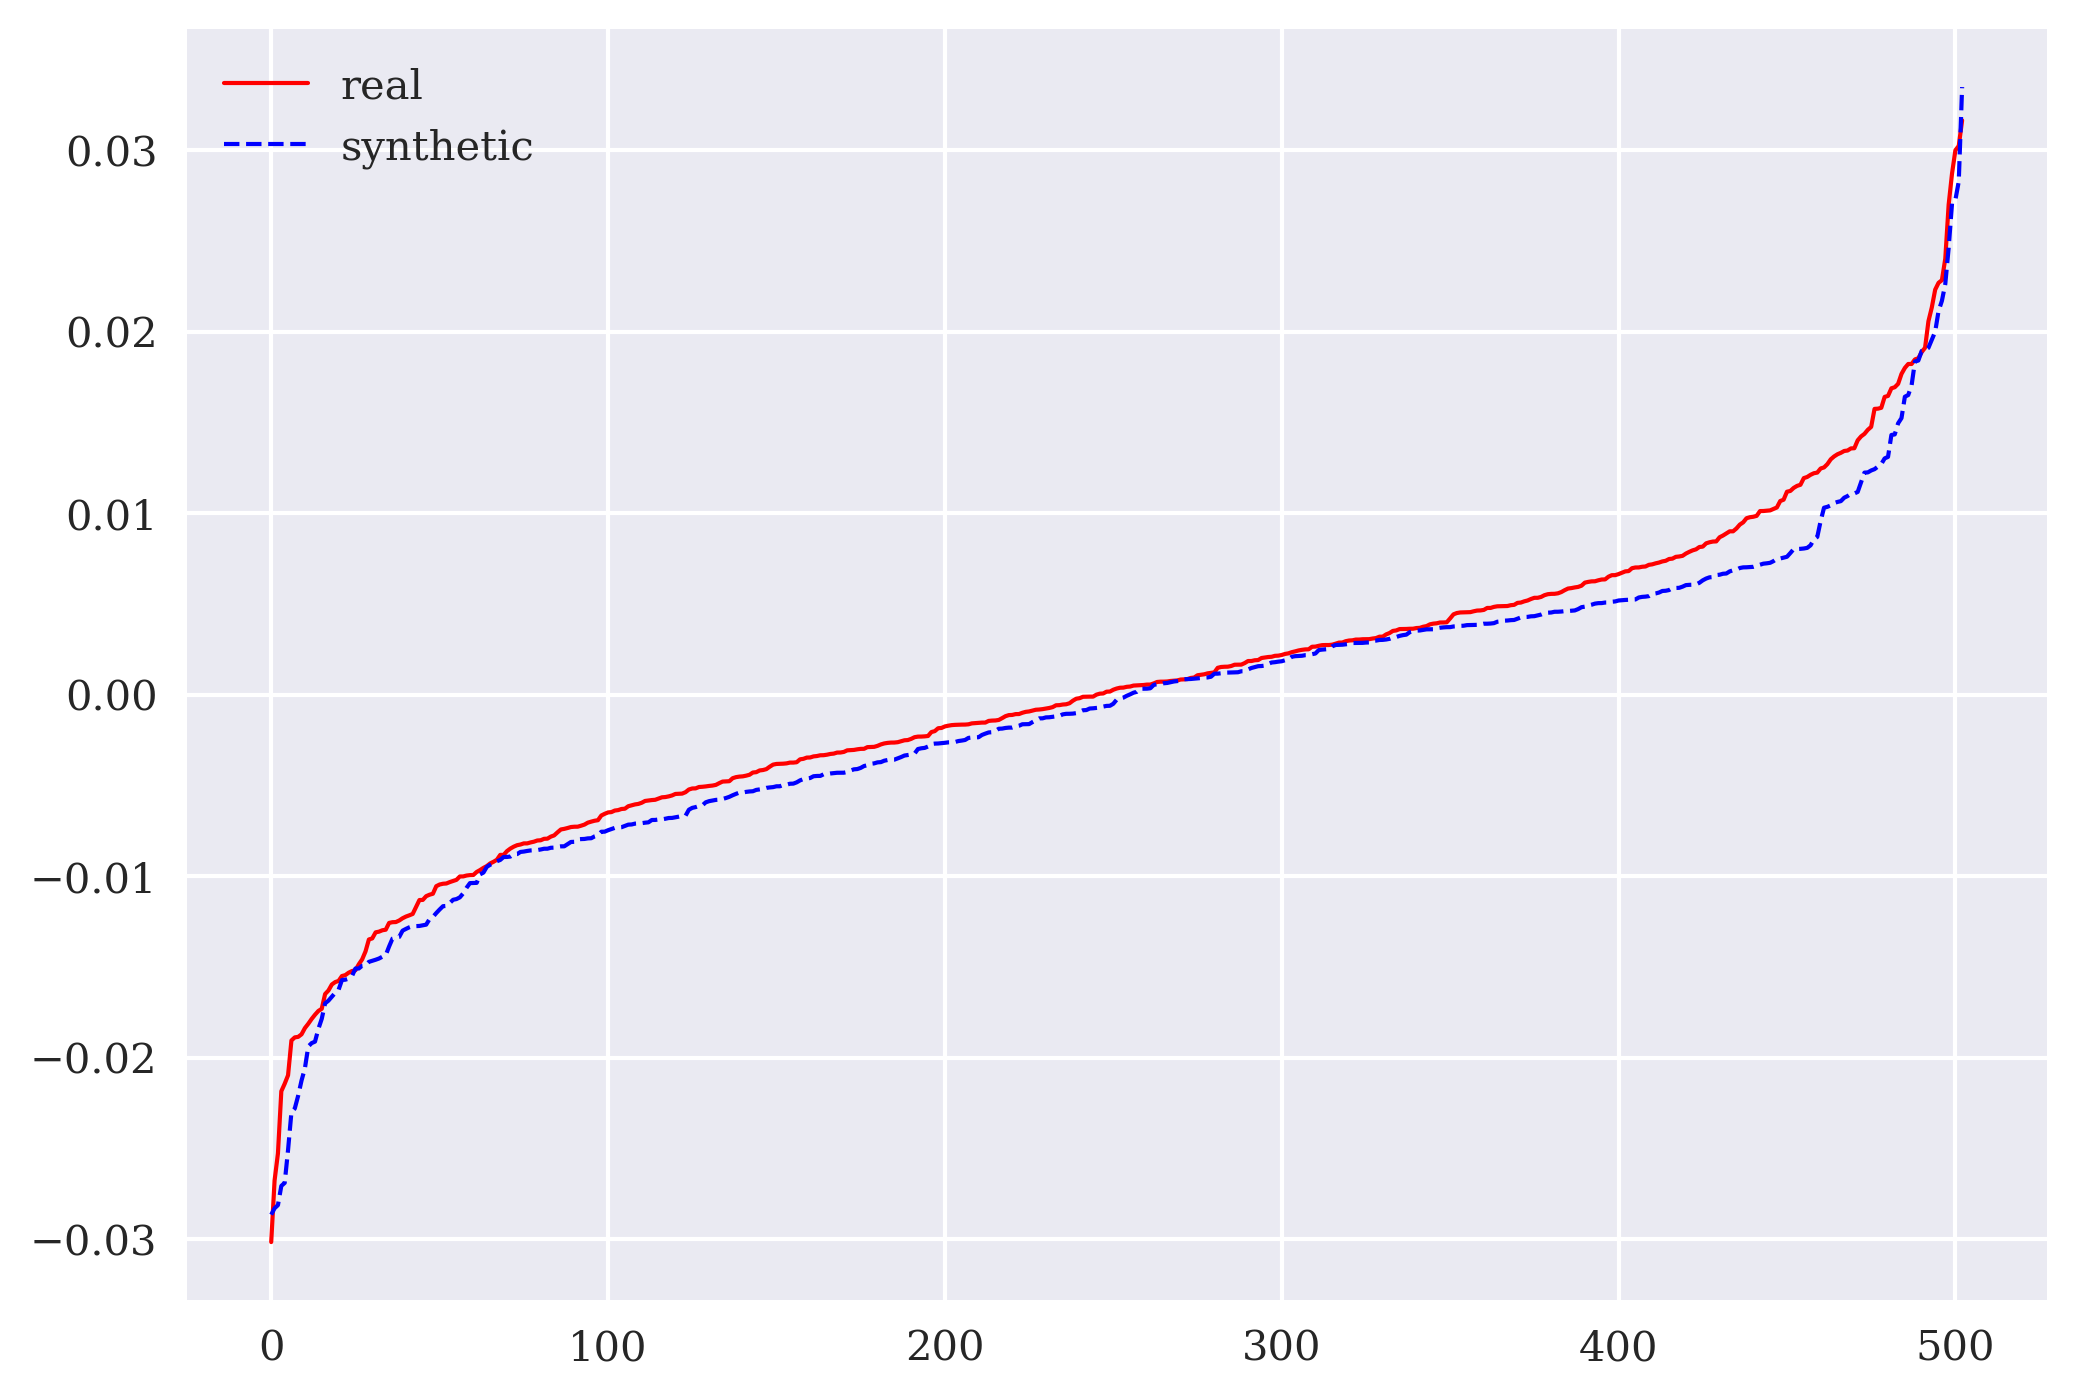

In [37]:
plt.plot(np.sort(data['real']), 'r', lw=1.0, label='real')
plt.plot(np.sort(data['synth_00']), 'b--', lw=1.0, label='synthetic')
plt.legend();

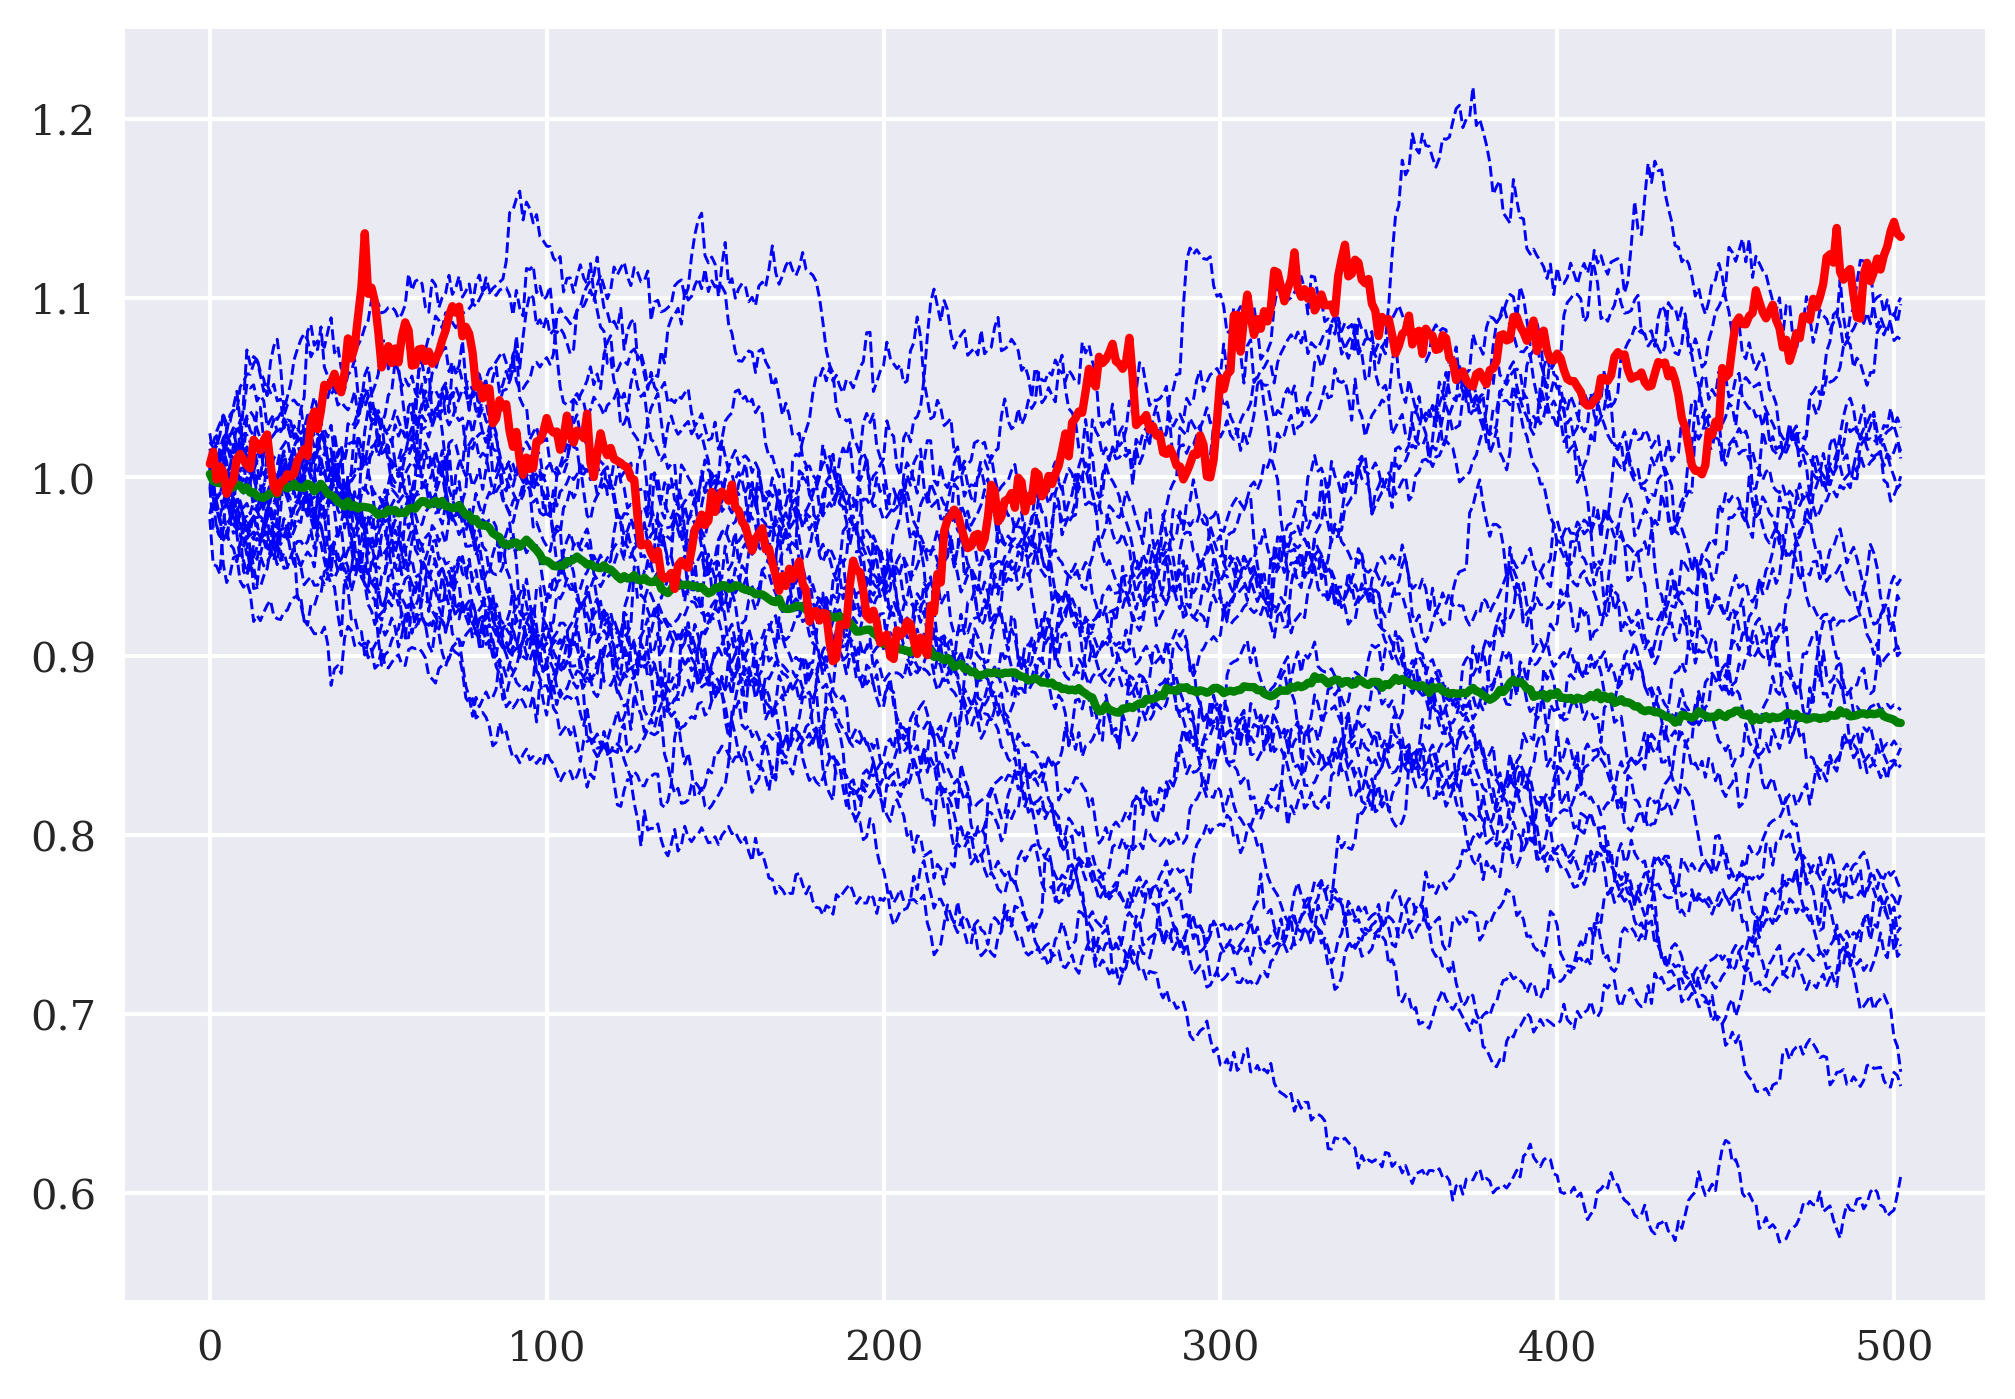

In [38]:
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(
    np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

### Kolmogorow-Smirnow (KS) Test

In [39]:
from scipy import stats

In [40]:
pvs = list()
for i in range(N):
    pvs.append(stats.kstest(data[f'synth_{i:02d}'],
                            data['real']).pvalue)
pvs = np.array(pvs)

In [41]:
np.sort((pvs > 0.05).astype(int))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [42]:
sum(np.sort(pvs > 0.05)) / N

1.0

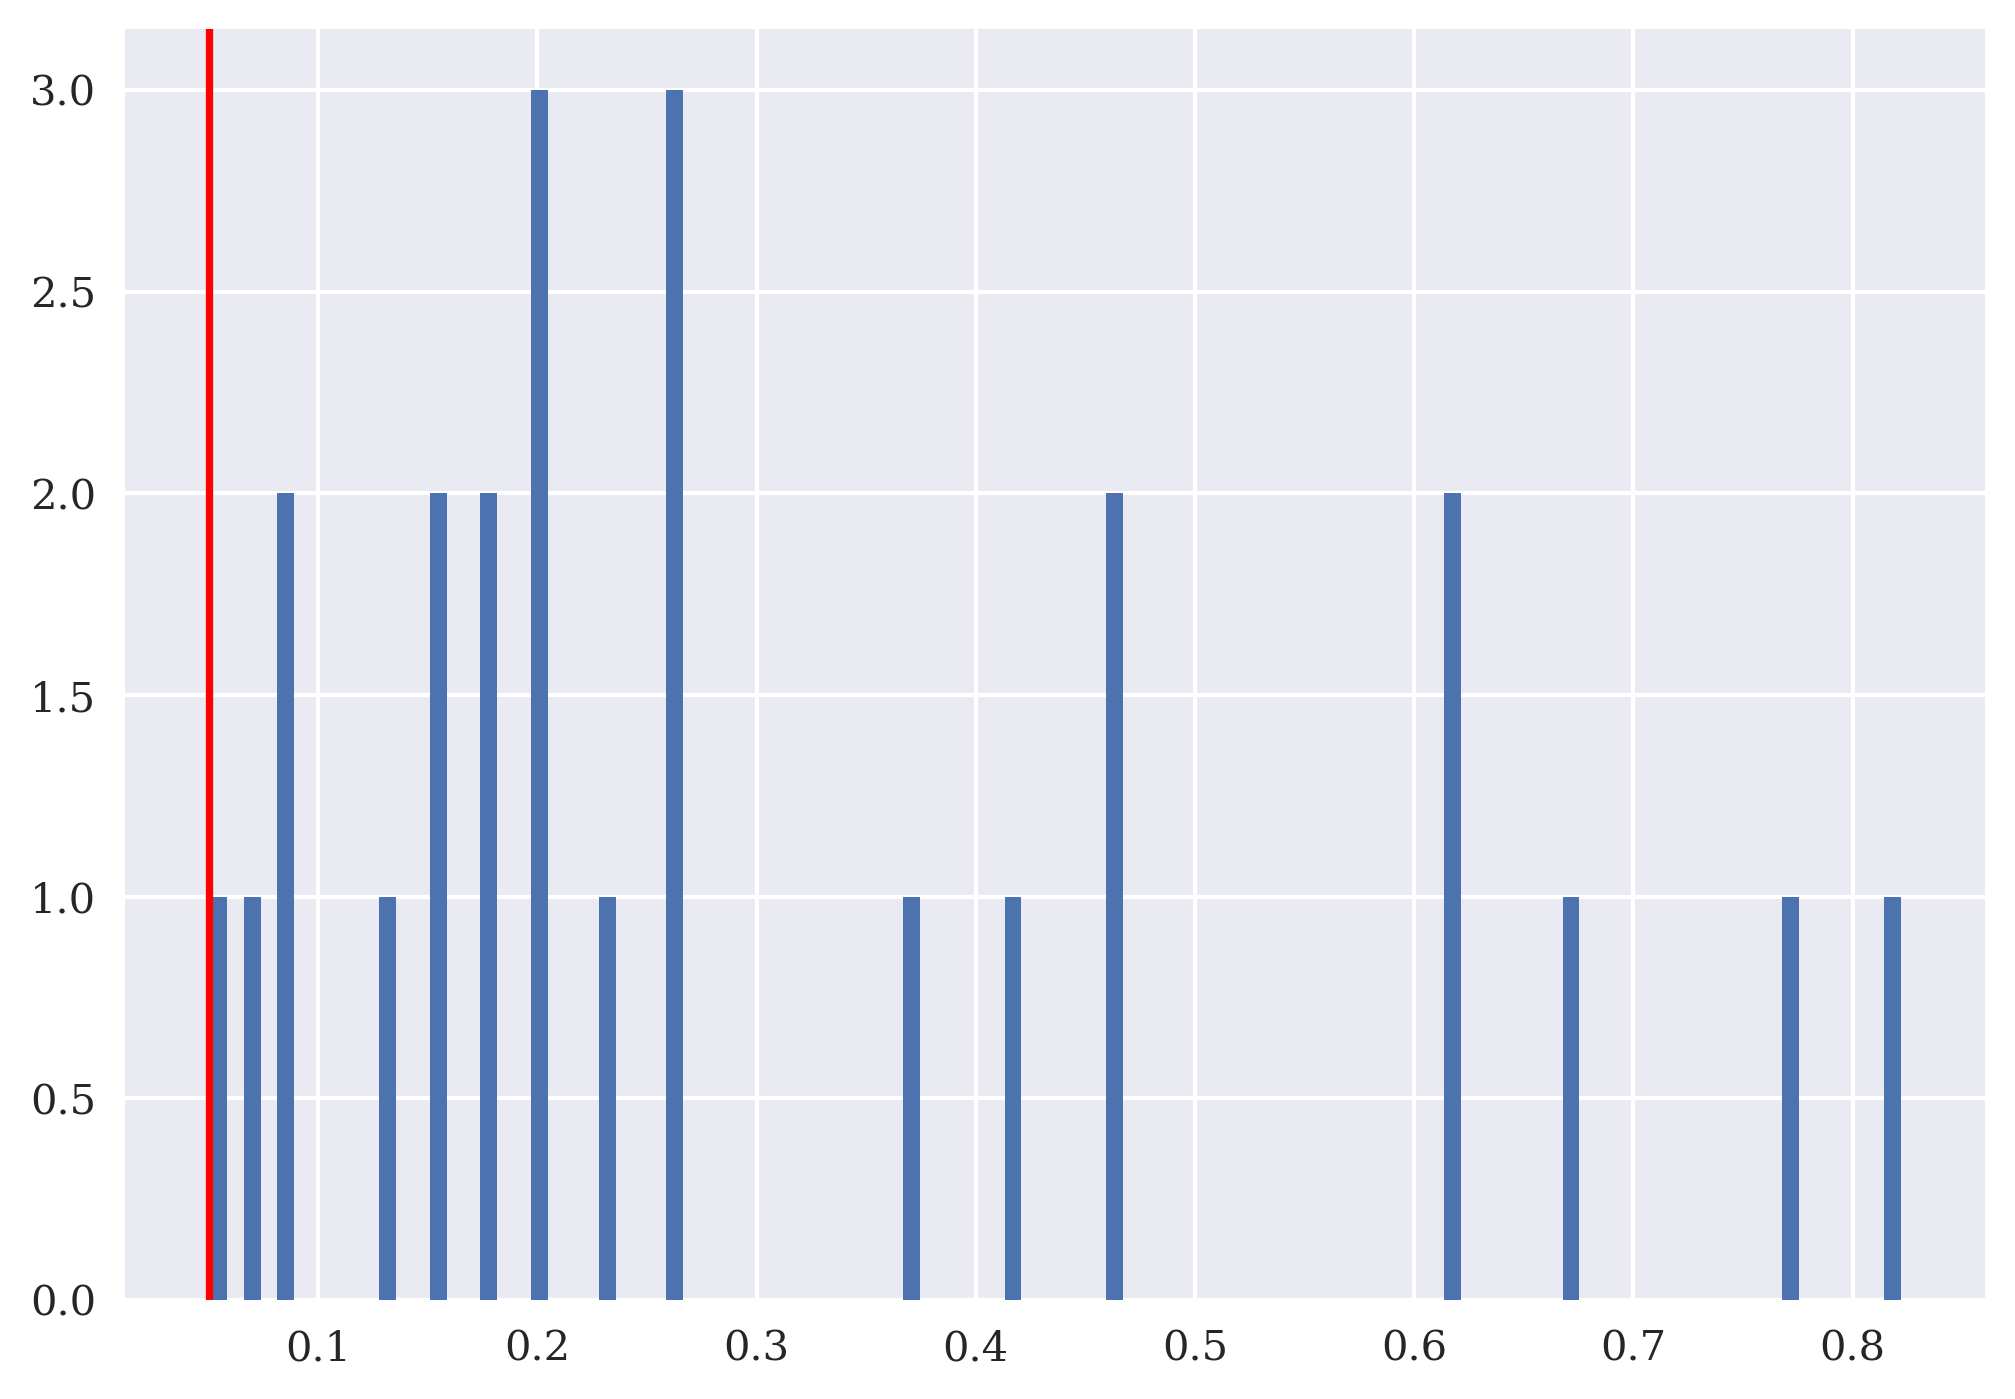

In [43]:
plt.hist(pvs, bins=100)
plt.axvline(0.05, color='r');

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>